In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../module/')

import keras2
from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
from util import moving_average, dlqr, discretized_system, lqr
import gym2
from rl2.agents import DDPGAgent
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [10]:
# GymのPendulum環境を作成
dt = 0.05
env = gym2.make("Pendulum-v1", dt)
clip = 10.
env.max_torque, max_torque = clip, clip
env.action_space.high, env.action_space.low = max_torque, -max_torque
control_interval = 1

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [11]:
def actor_net(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input)
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(2, activation="multiple_tanh")(x)
    actor = Model(inputs=action_input, outputs=x)
    return actor

def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

In [12]:
def agent(a_shape, s_shape):
    actor = actor_net(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = DDPGAgent(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory
    )
    return agent

In [ ]:
#safe learning
step = 300000
episode_step = int(200 * 0.05 / (dt * control_interval)) # 入力が加えられる回数を200(dt=0.05)にする
a = agent((2,), (2,))
a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"])
# a.load_weights('../learned_models_vol2/0.5standup-agent.h5')
# a.load_weights('../../learned_models_stab/lqr_optimal_agent.h5')
out = a.fit(env, nb_steps=step, visualize=0, verbose=1, nb_max_episode_steps=episode_step, action_repetition=control_interval)

episode_rewards = out.history["episode_reward"]

Training for 300000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 40s 4ms/step - reward: -3.8790
50 episodes - episode_reward: -775.807 [-1338.655, -283.645] - loss: 3.734 - mean_absolute_error: 2.045 - mean_q: -6.401

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 42s 4ms/step - reward: -3.7011
50 episodes - episode_reward: -740.215 [-1026.980, -604.672] - loss: 15.462 - mean_absolute_error: 2.626 - mean_q: -35.585

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 43s 4ms/step - reward: -3.1451
50 episodes - episode_reward: -629.015 [-1465.490, -253.650] - loss: 33.794 - mean_absolute_error: 2.861 - mean_q: -36.219

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 45s 4ms/step - reward: -3.9268
50 episodes - episode_reward: -785.368 [-1576.395, -22.659] - loss: 25.198 - mean_absolute_error: 2.456 - mean_q: -23.035

Interval 5 (40000 steps perfo

NameError: name 'l' is not defined

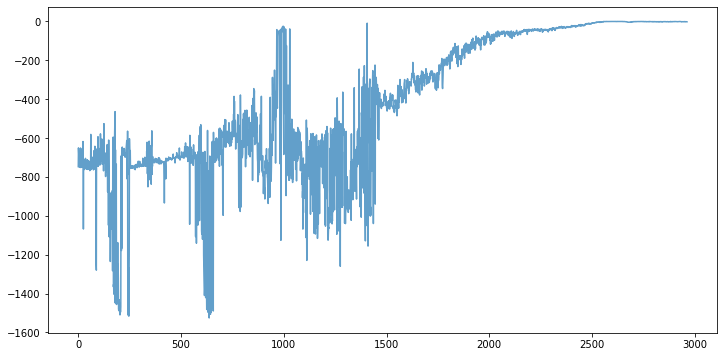

In [9]:
lma = 30
plt.figure(figsize=(12,6))
ma = moving_average(episode_rewards, lma)
plt.plot(range(len(episode_rewards)), episode_rewards, alpha=0.7)
plt.plot(range(lma, len(episode_rewards)), ma, label=f'{lma} moving average', alpha=0.7)
plt.xlabel('episode')
plt.ylabel('accumulated reward')
plt.title('episode transition')
plt.legend()
plt.show()